#https://www.tensorflow.org/tutorials/images/classification

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)


228827136/228813984 [==============================] - 2s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


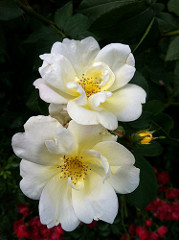

In [31]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
   




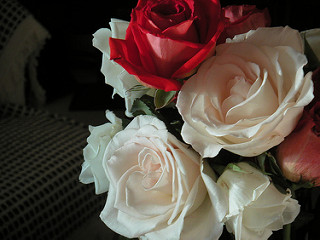

In [32]:
PIL.Image.open(str(roses[1]))

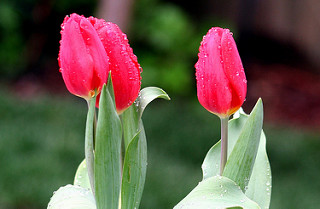

In [33]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


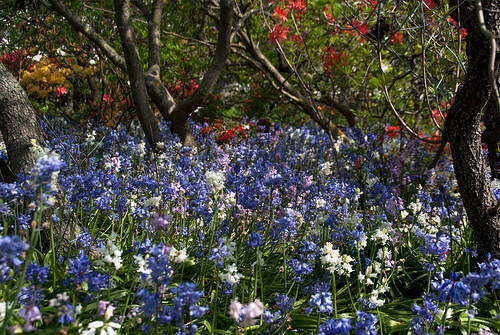

In [34]:
PIL.Image.open(str(tulips[1]))


In [35]:
#Defining parameters for the loader
batch_size = 32
img_height = 180
img_width = 180


In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [38]:
#Accessing the classnames
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


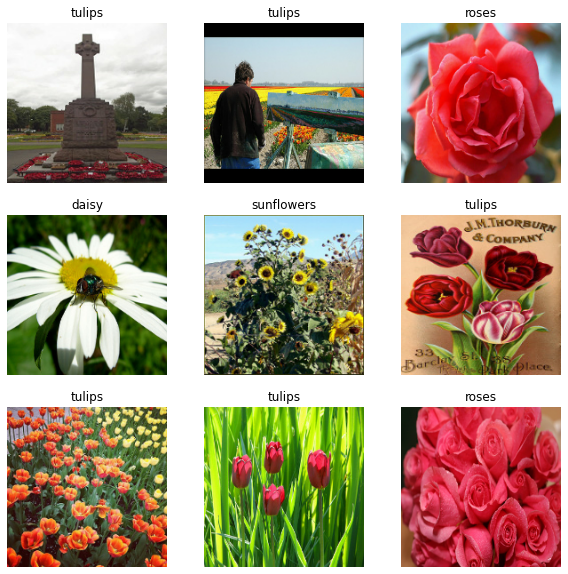

In [44]:
#Visualising code/ first 9 images from the training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
size = 9
for images, labels in train_ds.take(1):
  for i in range(size):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [45]:
#Training a model is done by passing the data to the Model.fit function, it is also possible to
#manually iterate over the dataset and retrieve batches of images

#Tensor - Multi-dimentional data array

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 180, 180, 3)
(32,)


In [46]:
#Configuring a dataset for performance
#2 important methods to use when loading data - 

#Dataset.cache - keeps images in memory after they're loaded off disk during the first epoch.
#Ensures the dataset does not become a bottleneck while traning a model.
#If dataset is too large to fit in memory this method creates a performant on-disk cache

#Dataset.prefetch - overlaps data preprocessing and model execution while training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [48]:
#Standardize the data 
#this normalises the data between the ranges of 0 to 1

normalization_layer = layers.Rescaling(1./255)


In [49]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.9722767


In [50]:
#Creating a model

#The sequential model consists of three convolution blocks with a max pooling layer in each of them.
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [53]:
#Compiling a model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
#Model summrary - view all layers of the network using the model's Model Summary Method
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [55]:
#Training the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
92/92 [==============================] - 31s 332ms/step - loss: 1.2611 - accuracy: 0.4666 - val_loss: 1.0423 - val_accuracy: 0.5872
Epoch 2/10
92/92 [==============================] - 30s 326ms/step - loss: 0.9863 - accuracy: 0.6042 - val_loss: 0.9236 - val_accuracy: 0.6308
Epoch 3/10
92/92 [==============================] - 30s 330ms/step - loss: 0.8137 - accuracy: 0.6819 - val_loss: 0.8541 - val_accuracy: 0.6771
Epoch 4/10
92/92 [==============================] - 30s 324ms/step - loss: 0.5869 - accuracy: 0.7837 - val_loss: 1.0112 - val_accuracy: 0.6158
Epoch 5/10
92/92 [==============================] - 29s 320ms/step - loss: 0.3917 - accuracy: 0.8638 - val_loss: 0.9683 - val_accuracy: 0.6703
Epoch 6/10
92/92 [==============================] - 29s 319ms/step - loss: 0.1865 - accuracy: 0.9407 - val_loss: 1.2481 - val_accuracy: 0.6444
Epoch 7/10
92/92 [==============================] - 30s 327ms/step - loss: 0.1158 - accuracy: 0.9663 - val_loss: 1.4740 - val_accuracy: 0.6431

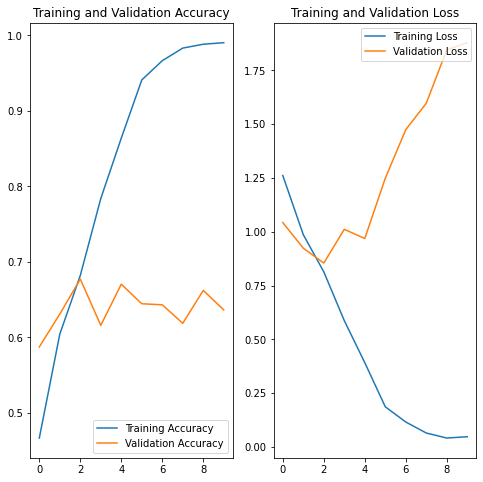

In [56]:
#Visualising the training history
# This can be done by creating plots of loss and accuracy on the training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The plots show that the training and validation accuracy is off by a large margin and the model
#achieves under 70% accuracy on the validation set.

In [57]:
#Overfitting - Not enough training examples to properly 
#teach a neural network results in the network learning from noise and unwanted data
#This results in a high training accuracy meaning the network is learning alot of things 
#but a low validation accuracy which means the netork is learning the wrong things.

#Data augemtation can deal with overfitting by generating additional training data from existing examples
#by augmenting them using random transformations that yield believable-looking images.
#Exposing the model to more aspects of data for better generilization.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


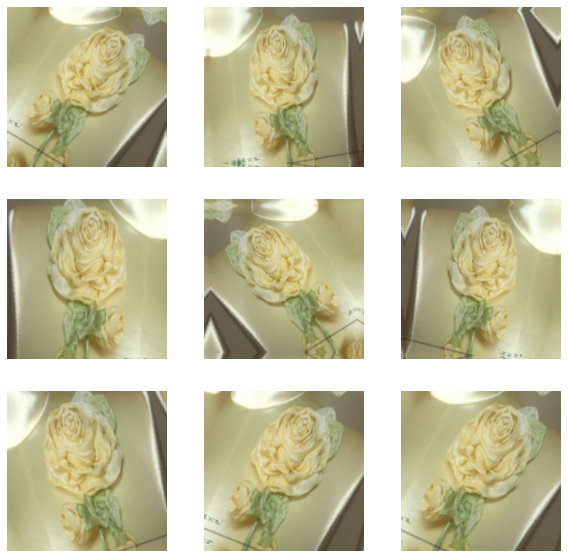

In [58]:
#Visualising what data augementation looks like on a single image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [59]:
#Dropout is a technique that reduces overfitting by randomly dropping out (setting the activation to zero)
#a number of output units from the layer during the training process
#It takes a fractional number as its input value in the form such as 0.1,0.2,e.t.c
#Meaning fripping out 10%...20% of the output units randomly from the applied layer.
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),#dropout executed here
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [60]:
#Compiling a new neural network model to be trained by augmented images
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [61]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [62]:
#Training the new model...
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 33s 358ms/step - loss: 1.3006 - accuracy: 0.4268 - val_loss: 1.1259 - val_accuracy: 0.5450
Epoch 2/15
92/92 [==============================] - 33s 355ms/step - loss: 1.0180 - accuracy: 0.6029 - val_loss: 1.0297 - val_accuracy: 0.5981
Epoch 3/15
92/92 [==============================] - 33s 356ms/step - loss: 0.9223 - accuracy: 0.6427 - val_loss: 0.9344 - val_accuracy: 0.6253
Epoch 4/15
92/92 [==============================] - 32s 350ms/step - loss: 0.8582 - accuracy: 0.6672 - val_loss: 0.8369 - val_accuracy: 0.6662
Epoch 5/15
92/92 [==============================] - 33s 354ms/step - loss: 0.8246 - accuracy: 0.6839 - val_loss: 0.8351 - val_accuracy: 0.6730
Epoch 6/15
92/92 [==============================] - 32s 351ms/step - loss: 0.7824 - accuracy: 0.6955 - val_loss: 0.8068 - val_accuracy: 0.6757
Epoch 7/15
92/92 [==============================] - 32s 352ms/step - loss: 0.7269 - accuracy: 0.7306 - val_loss: 0.8149 - val_accuracy: 0.6771

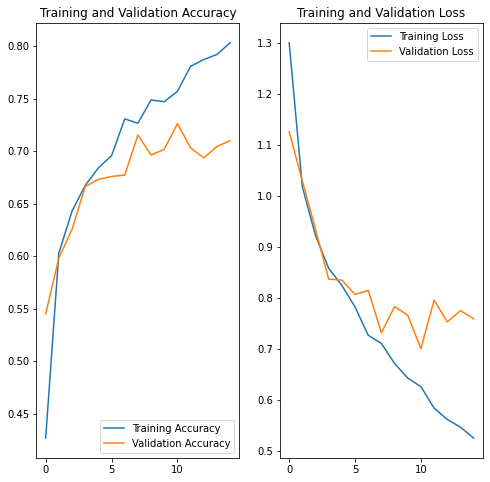

In [63]:
#Visualise new training results  on the neural network model with augemented data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [64]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to sunflowers with a 97.84 percent confidence.
